In [36]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
import easydarkfigs
import pcmdpy as ppy
from numpy.linalg import eig, inv
%matplotlib inline

In [43]:
def get_XY(image):
    ny, nx = image.shape
    Y, X = np.mgrid[:ny, :nx]
    return X, Y

In [68]:
def get_RTheta(image, xc=0, yc=0):
    X, Y = get_XY(image)
    X = X - xc
    Y = Y - yc
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    return R, Theta

# NGC 4993

In [3]:
f = ppy.instrument.default_ngc4993_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [6]:
with fits.open('../data/NGC4993/reduced/NGC4993_F850LP_drc.fits') as h:
    f850lp = f[0].counts_to_mag(h['SCI'].data)
    regions = h['REGIONS'].data
with fits.open('../data/NGC4993/reduced/NGC4993_F475W_drc.fits') as h:
    f475w = f[1].counts_to_mag(h['SCI'].data)

In [8]:
mags = f850lp
colors = f475w - f850lp

In [164]:
def plot_image(image, mask, ax=None):
    """
    Plot an image, with only a particular mask of a region shown
    """
    im = np.zeros_like(image)
    data = image[mask]
    im[mask] = data
    im[~mask] = np.nan
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=np.percentile(data, 1), vmax=np.percentile(data, 99)), cmap='viridis_r')
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar()
    return ax

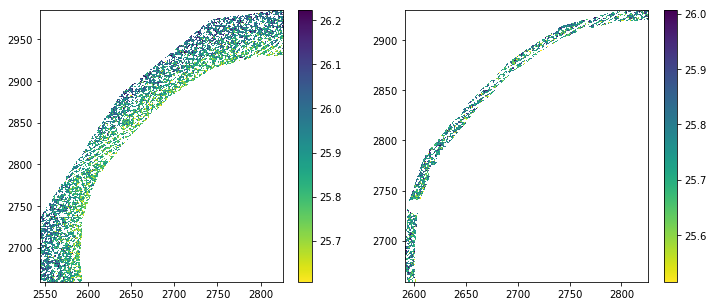

In [163]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
plot_image(mags, (regions == 70), ax=axes[0])
plot_image(mags, (regions == 74), ax=axes[1])

In [167]:
def correct_angle(theta):
    """
    Convert an angle theta (or array of angles) to [-pi, pi)
    """
    if isinstance(theta, float):
        if theta < -np.pi:
            return theta + 2*np.pi
        elif theta >= np.pi:
            return theta - 2*np.pi
        else:
            return theta
    else:
        theta[theta < -np.pi] += 2*np.pi
        theta[theta >= np.pi] -= 2*np.pi
    return theta

In [168]:
def is_between(thetas, lower, upper):
    """
    Evaluate if angles thetas are between lower and upper (including circularity)
    """
    lower, upper = correct_angle(np.array([lower, upper]))
    if lower <= upper:
        return (lower <= thetas) & (thetas <= upper)
    else:  # if upper loops around
        return (upper <= thetas) & (thetas <= lower)

In [214]:
def getEllipseParamsManual(mask, xc, yc, dtheta=0.05):
    """
    Given an image mask corresponding to a roughly-elliptical region, compute the elliptical
    parameters corresponding to the inner edge.
    
    Parameters
    ==========
    mask : 
    xc, yc : center position of the ellipse
    dtheta : allowed angular region to search for semi-major axis
    
    Returns
    =======
    xc, yc : central positions of the ellipse
    a : semi-major axis (scaled to unit 1)
    b : semi-minor axis (scaled to unit 1)
    r : scale radius of the ellipse (in pixels)
    phi : position angle
    """
    R, Theta = get_RTheta(mask, xc=xc, yc=yc)
    # Compute the radius to nearest inner edge (semi-minor axis)
    R = R[mask]
    Theta = Theta[mask]
    b = R.min()
    Theta_min = Theta[R.argmin()]
    # Look at points at +/- 90 degrees from inner-most edge
    t1, t2 = correct_angle(np.array([-dtheta, dtheta]) + Theta_min - np.pi/2)
    t3, t4 = correct_angle(np.array([-dtheta, dtheta]) + Theta_min + np.pi/2)
    far_mask_1 = is_between(Theta, t1, t2)
    far_mask_2 = is_between(Theta, t3, t4)
    # Compute the radius to farthest inner edge (semi-major axis)
    a_1 = R[far_mask_1].min() if far_mask_1.sum() > 0 else None
    a_2 = R[far_mask_2].min() if far_mask_2.sum() > 0 else None
    if (a_1 is not None) and (a_2 is not None):
        a = 0.5 * (a_1 + a_2)
    elif (a_1 is not None):
        a = a_1
    elif (a_2 is not None):
        a = a_2
    else:
        a = b
    Theta_max = correct_angle(Theta_min + np.pi/2.)
    r = np.sqrt(a**2 + b**2)
    phi = Theta_max
    return xc, yc, a/r, b/r, r, phi

In [268]:
class EllipticalFit:
    
    def __init__(self, mask, xc, yc, dtheta=0.05):
        self.xc = xc
        self.yc = yc
        _, _, self.a, self.b, self.r, self.phi = getEllipseParamsManual(mask, xc=xc, yc=yc, dtheta=dtheta)
        self.mask = mask
        
    def plot_ellipse(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        R = np.arange(0, 2*np.pi, 0.01)
        t1, t2 = self.a*self.r, self.b*self.r
        xx = self.xc + t1*np.cos(R)*np.cos(self.phi) - t2*np.sin(R)*np.sin(self.phi)
        yy = self.yc + t1*np.cos(R)*np.sin(self.phi) + t2*np.sin(R)*np.cos(self.phi)
        ax.plot(xx, yy, 'r:')
        return ax
    
    def transform(self, mask=None):
        if mask is None:
            mask = self.mask
        Xs, Ys = get_XY(mask)
        X, Y = (Xs[mask] - self.xc), (Ys[mask] - self.yc)
        X_rot = X*np.cos(-self.phi) - Y*np.sin(-self.phi)
        Y_rot = Y*np.cos(-self.phi) + X*np.sin(-self.phi)
        r = np.sqrt((X_rot / self.a)**2 + (Y_rot / self.b)**2)
        theta = np.arctan2(Y_rot/b, X_rot/a)
        return r, theta
    
    def plot_radii(self, mask=None, ax=None):
        if mask is None:
            mask = self.mask
        rs, thetas = self.transform(mask)
        im = np.zeros_like(mask, dtype=float)
        im[mask] = rs
        im[~mask] = np.nan
        if ax is None:
            fig, ax = plt.subplots()
        plt.subplot(ax)
        plt.imshow(im, norm=mpl.colors.Normalize(vmin=rs.min(), vmax=rs.max()))
        ys, xs = np.where(mask)
        ax.set_xlim([xs.min(), xs.max()])
        ax.set_ylim([ys.min(), ys.max()])
        plt.colorbar()
        return ax
    
    def plot_radial_gradient(self, values, mask=None, ax=None, n_bins=10, **kwargs):
        if mask is None:
            mask = self.mask
        R, Theta = self.transform(mask)
        y = values[mask]
        kw = {'x_estimator': np.median,
              'x_bins': n_bins,
             'x_ci': 'sd'}
        kw.update(kwargs)
        if ax is None:
            fig, ax = plt.subplots()
        sns.regplot(x=R, y=y, ax=ax, **kw)
        return ax
    
    def plot_angular_gradient(self, values, mask=None, ax=None, n_bins=10, **kwargs):
        if mask is None:
            mask = self.mask
        R, Theta = self.transform(mask)
        y = values[mask]
        kw = {'x_estimator': np.median,
              'x_bins': n_bins,
             'x_ci': 'sd'}
        kw.update(kwargs)
        if ax is None:
            fig, ax = plt.subplots()
        sns.regplot(x=Theta, y=y, ax=ax, **kw)
        return ax
    
    def delta_val(self, values, mask=None, n_bins=10, func=np.median, 
                 subtract=True):
        if mask is None:
            mask = self.mask
        R, Theta = self.transform(mask)
        y = values[mask]
        bins = np.linspace(R.min()-0.01, R.max()+0.01, n_bins+1)
        ids = np.digitize(R, bins)
        inner = (ids == 1)
        outer = (ids == n_bins)
        if subtract:
            return func(y[outer]) - func(y[inner])
        else:
            return func(y[outer]) / func(y[inner])

In [269]:
mask = (regions >= 65)&(regions < 69)
fit_66 = EllipticalFit(mask, xc=2827, yc=2659)

In [270]:
mask = (regions >= 69)&(regions < 73)
fit_70 = EllipticalFit(mask, xc=2827, yc=2659)

In [271]:
mask = (regions >= 73)&(regions < 77)
fit_74 = EllipticalFit(mask, xc=2827, yc=2659)

In [275]:
fit_66.delta_val(mags, (regions == 65))

0.023456573

In [276]:
fit_66.delta_val(mags, (regions == 66))

0.10349655

In [277]:
fit_66.delta_val(mags, (regions == 67))

0.13357353

In [278]:
fit_66.delta_val(mags, (regions == 68))

0.14215851

In [273]:
fit_70.delta_val(mags)

0.23585892

In [274]:
fit_74.delta_val(mags)

0.050441742

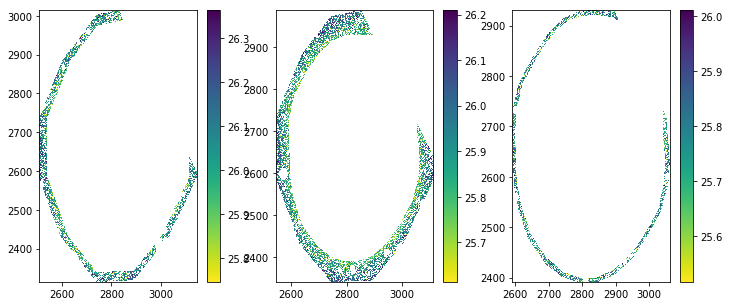

In [279]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
plot_image(mags, mask=fit_66.mask, ax=axes[0])
plot_image(mags, mask=fit_70.mask, ax=axes[1])
plot_image(mags, mask=fit_74.mask, ax=axes[2])

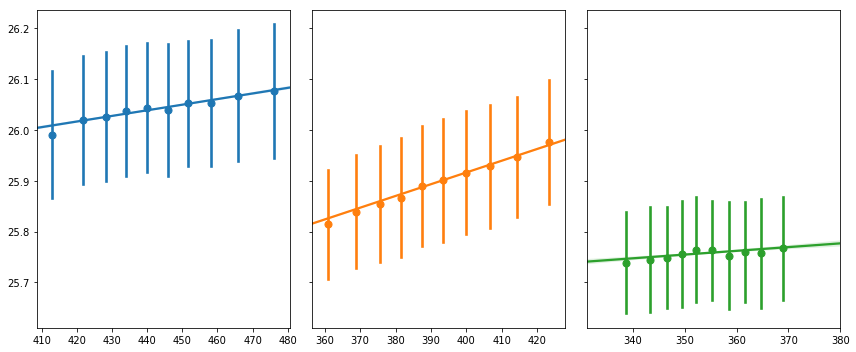

In [226]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5), sharey=True)
fit_66.plot_radial_gradient(mags, ax=axes[0])
fit_70.plot_radial_gradient(mags, ax=axes[1])
fit_74.plot_radial_gradient(mags, ax=axes[2])
axes[2].set_xlim(xmax=380)
plt.tight_layout()

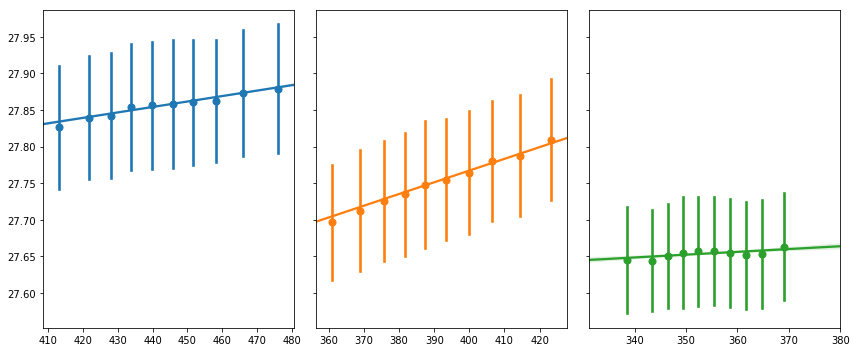

In [231]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5), sharey=True)
fit_66.plot_radial_gradient(colors+mags, ax=axes[0])
fit_70.plot_radial_gradient(colors+mags, ax=axes[1])
fit_74.plot_radial_gradient(colors+mags, ax=axes[2])
axes[2].set_xlim(xmax=380)
plt.tight_layout()